In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, Matern

**First, read our snow area (measured in # of pixels at 10m resolution) into a dataframe. We only use data for the northern cairngorms region.**

In [2]:
time_series_path = "scl_time_series.csv"
df = pd.read_csv(time_series_path, index_col=0)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date")
df = df[df["name"] == "northern_cairngorms"][["date", "snow_px"]]
df

,date,snow_px
8,2018-03-26 11:21:09,0
300,2018-04-01 11:43:49,683165
292,2018-04-05 11:21:09,0
664,2018-04-20 11:21:21,0
844,2018-04-21 11:43:49,110350
...,...,...
820,2023-06-14 11:43:49,1273
452,2023-06-16 11:33:21,1020
644,2023-06-18 11:21:19,0
864,2023-07-08 11:21:19,0


<Axes: xlabel='date'>

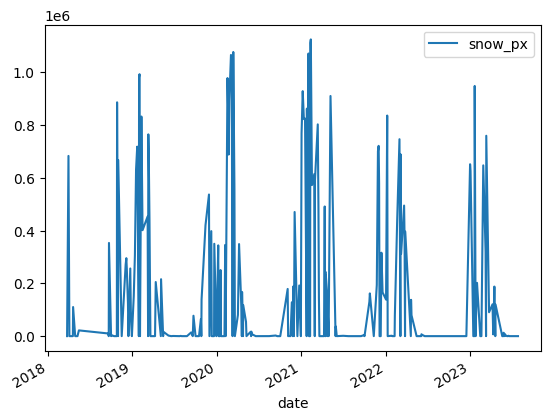

In [3]:
df.plot(x="date")

**Rescale the dates into a fractional time with units of years, and rescale the snow measurements to 0 to 100 as well.**

In [4]:
start_time = df["date"].min()
end_time = df["date"].max()
time_length = end_time - start_time
num_years = time_length.days / 365
max_snow = df["snow_px"].max()
df = df.apply(lambda row: (num_years * (row["date"] - start_time) / time_length, 100.0 * row["snow_px"] / max_snow), axis=1, result_type="broadcast")
print(df)

         date    snow_px
8         0.0        0.0
300  0.016481  60.730474
292  0.027397        0.0
664  0.068493        0.0
844  0.071276   9.809648
..        ...        ...
820  5.221938   0.113164
452  5.227398   0.090674
644  5.232854        0.0
864  5.287649        0.0
740  5.336986        0.0

[280 rows x 2 columns]


**We want to interpolate between these values using a Gaussan process.**
**First, decide on a kernel function. We use the sum of a radial basis kernel (to capture long trends) and a periodic kernel (to capture seasonality). The fit() function then finds the kernel parameters (e.g. length scale and amplitude) which maximise the log-likelihood of our observed data. I think it's just performing gradient descent optimisation under the hood.**

We use the kernel examples from https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py here:

In [5]:
X_train = df["date"].array.reshape(-1, 1).astype(np.float64)
y_train = df["snow_px"].array.astype(np.float64)

In [6]:
# Try a GP with kernels to model short term / high frequency noise

noise_std=5.0

seasonal_kernel_1 = (
    1.0**2
    * RBF(length_scale=5, length_scale_bounds=(5, 10))
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed", length_scale_bounds=(0.1, 1.0))
)

seasonal_kernel_2 = (
    1.0**2
    * RBF(length_scale=5, length_scale_bounds=(5, 10))
    * ExpSineSquared(length_scale=0.1, periodicity=1.0, periodicity_bounds="fixed", length_scale_bounds=(0.01, 0.1))
)

matern_kernel = 10.0 * Matern()
irregularities_kernel = 10.0**2 * RationalQuadratic(length_scale=0.01, alpha=1.0)

noise_kernel =  WhiteKernel(noise_level=noise_std, noise_level_bounds="fixed") 

kernel = seasonal_kernel_1 + seasonal_kernel_2 + matern_kernel + noise_kernel + irregularities_kernel

gaussian_process_1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gaussian_process_1.fit(X_train, y_train)
gaussian_process_1.kernel_

/home/murray/miniconda3/envs/gpy/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__k2__length_scale is close to the specified upper bound 10. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/murray/miniconda3/envs/gpy/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__k2__length_scale is close to the specified upper bound 10. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/murray/miniconda3/envs/gpy/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.

16.6**2 * RBF(length_scale=10) * ExpSineSquared(length_scale=0.978, periodicity=1) + 15.5**2 * RBF(length_scale=10) * ExpSineSquared(length_scale=0.01, periodicity=1) + 1.09**2 * Matern(length_scale=1.77e+04, nu=1.5) + WhiteKernel(noise_level=5) + 17.2**2 * RationalQuadratic(alpha=0.109, length_scale=2.29e-05)

In [54]:
# A much smoother kernel

noise_std=5.0

long_term_kernel = 1.0**2 * RBF(length_scale=1, length_scale_bounds="fixed")

seasonal_kernel_1 = (
    1.0**2
    * RBF(length_scale=5.0, length_scale_bounds="fixed")
    * ExpSineSquared(length_scale=0.5, periodicity=1.0, periodicity_bounds="fixed", length_scale_bounds="fixed")
)

noise_kernel = 1.0 * WhiteKernel(noise_level=noise_std, noise_level_bounds=(1.0, 100.0)) 

kernel = long_term_kernel + noise_kernel + seasonal_kernel_1 #+ seasonal_kernel_2 + noise_kernel

gaussian_process_2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gaussian_process_2.fit(X_train, y_train)
gaussian_process_2.kernel_

2.85**2 * RBF(length_scale=1) + 2.19**2 * WhiteKernel(noise_level=99.6) + 16**2 * RBF(length_scale=5) * ExpSineSquared(length_scale=0.5, periodicity=1)

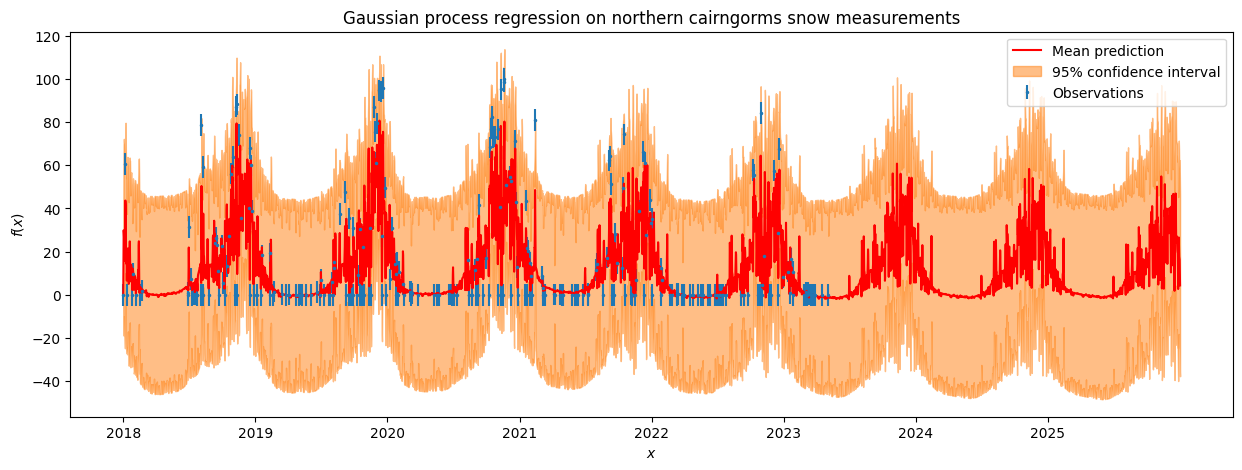

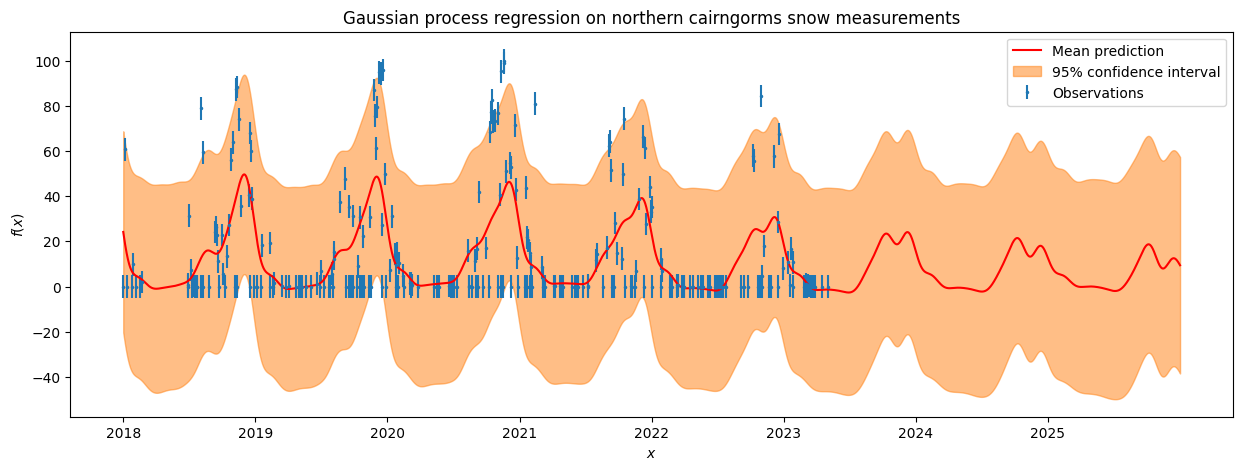

In [55]:
def plot_gpr(gaussian_process):
    n_months = 8
    X = np.linspace(start=0, stop=n_months, num=5_000).reshape(-1, 1)
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    
    fig = plt.figure(figsize=(15, 5))
    
    plt.errorbar(
        X_train,
        y_train,
        noise_std,
        linestyle="None",
        color="tab:blue",
        marker=".",
        markersize=3,
        label="Observations",
    )
    plt.plot(X, mean_prediction, label="Mean prediction", color="red")
    plt.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        color="tab:orange",
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.xticks(range(n_months), labels=[f"20{n}" for n in range(18, 18 + n_months)])
    _ = plt.title("Gaussian process regression on northern cairngorms snow measurements")

plot_gpr(gaussian_process_1)
plot_gpr(gaussian_process_2)

**It is difficult to find a kernel function which fits this data well. Next steps: try smoothing it into monthly averages?**

**I would also like to be able to set the noise on the data samples to be a relative error - e.g. the measurements of zero snow are probably accurate, so the gaussian process should show minimal uncertainty during the summers. It seems like it isn't possible to do this in scikit-learn?**